<a href="https://colab.research.google.com/github/Teja5164/Chess_pieces_detectionusingYOLOv8/blob/main/version3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python-headless python-chess matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 30.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=03c705023a8f17669cedf3fc7291cd47777840ac52bd1088a5f17ed4abee3552
  Stored in directory: /root/.cache/pip/wheels/83/1f/4e/8f4300f7dd554eb8de70ddfed96e94d3d030ace10c5b53d447
Successfully built chess


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import chess

def show_image(img, title="Image"):
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()


In [ ]:
def debug_show_threshold_and_contours(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)

    # Try adaptive threshold; you can switch to simple threshold if needed
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)
    # Show thresholded image
    show_image(cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR), "Thresholded Image")

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Draw all contours on a copy of original image
    img_contours = img.copy()
    cv2.drawContours(img_contours, contours, -1, (0,255,0), 2)
    show_image(img_contours, "All Contours")

    return contours


In [ ]:
def find_board(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)
    cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Total contours found: {len(cnts)}")

    big_contours = [c for c in cnts if cv2.contourArea(c) > 5000]
    big_contours = sorted(big_contours, key=cv2.contourArea, reverse=True)

    board_cnt = None

    # Try multiple approximation epsilon values for best 5 big contours
    for c in big_contours[:5]:
        peri = cv2.arcLength(c, True)
        for epsilon_factor in [0.02, 0.03, 0.04]:
            approx = cv2.approxPolyDP(c, epsilon_factor * peri, True)
            if len(approx) == 4:
                board_cnt = approx
                break
        if board_cnt is not None:
            break

    if board_cnt is None:
        print("No suitable 4-corner board contour found.")
        print("Trying fallback with largest contour bounding rect.")
        largest_contour = big_contours[0]
        x, y, w, h = cv2.boundingRect(largest_contour)
        board_cnt = np.array([
            [[x, y]],
            [[x + w, y]],
            [[x + w, y + h]],
            [[x, y + h]]
        ], dtype=np.int32)

    # Order points
    def order_points(pts):
        pts = pts.reshape(4,2)
        s = pts.sum(axis=1)
        diff = np.diff(pts, axis=1)
        ordered = np.zeros((4,2), dtype="float32")
        ordered[0] = pts[np.argmin(s)]
        ordered[2] = pts[np.argmax(s)]
        ordered[1] = pts[np.argmin(diff)]
        ordered[3] = pts[np.argmax(diff)]
        return ordered

    pts = order_points(board_cnt)
    side = max([
        np.linalg.norm(pts[0] - pts[1]),
        np.linalg.norm(pts[1] - pts[2]),
        np.linalg.norm(pts[2] - pts[3]),
        np.linalg.norm(pts[3] - pts[0]),
    ])
    dst = np.array([[0,0],[side-1,0],[side-1,side-1],[0,side-1]], dtype="float32")
    M = cv2.getPerspectiveTransform(pts, dst)
    warped = cv2.warpPerspective(image, M, (int(side), int(side)))
    return warped


In [ ]:
def split_board_into_squares(board_img):
    height, width = board_img.shape[:2]
    sq_size = height // 8
    squares = []

    for r in range(8):
        row_squares = []
        for c in range(8):
            x_start = c * sq_size
            y_start = r * sq_size
            square_img = board_img[y_start:y_start+sq_size, x_start:x_start+sq_size]
            row_squares.append(square_img)
        squares.append(row_squares)

    return squares


In [ ]:
def make_templates():
    templates = {}
    size = 50
    radius = 15

    wp = np.zeros((size, size), dtype=np.uint8)
    cv2.circle(wp, (size//2, size//2), radius, 255, -1)  # white pawn

    bp = np.zeros((size, size), dtype=np.uint8)
    cv2.circle(bp, (size//2, size//2), radius, 200, -1)  # black pawn

    templates['P'] = wp
    templates['p'] = bp

    return templates


In [ ]:
def detect_piece(sq_img, templates):
    gray = cv2.cvtColor(sq_img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    _, thresh = cv2.threshold(blur, 60, 255, cv2.THRESH_BINARY_INV)

    best_val = 0
    piece_found = None

    for piece, templ in templates.items():
        res = cv2.matchTemplate(thresh, templ, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, _ = cv2.minMaxLoc(res)
        if max_val > best_val and max_val > 0.5:
            best_val = max_val
            piece_found = piece

    return piece_found if piece_found else "unknown"


In [ ]:
def make_fen(board_list):
    fen_rows = []
    for row in board_list:
        fen_row = ""
        empty_count = 0
        for sq in row:
            if sq == "unknown" or sq is None:
                empty_count += 1
            else:
                if empty_count > 0:
                    fen_row += str(empty_count)
                    empty_count = 0
                fen_row += sq
        if empty_count > 0:
            fen_row += str(empty_count)
        fen_rows.append(fen_row)

    fen = "/".join(fen_rows)
    fen += " w - - 0 1"  # placeholders for now
    return fen


In [ ]:
def process_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise Exception(f"Image not found: {image_path}")

    board = find_board(img)
    show_image(board, "Board Top-Down View")

    squares = split_board_into_squares(board)
    templates = make_templates()

    pieces_board = []
    for row in squares:
        row_pieces = []
        for sq in row:
            piece = detect_piece(sq, templates)
            row_pieces.append(piece)
        pieces_board.append(row_pieces)

    for r in pieces_board:
        print(r)

    fen = make_fen(pieces_board)
    print("FEN:", fen)

    try:
        chess.Board(fen)
        print("Valid FEN!")
    except Exception as e:
        print(f"FEN invalid: {e}")

    return fen


Saving 1.jpeg to 1 (5).jpeg
Saving 2.jpeg to 2 (6).jpeg
Saving 3.jpeg to 3 (6).jpeg
Saving 4.jpeg to 4 (6).jpeg
Saving 5.jpeg to 5 (6).jpeg
Processing 1 (5).jpeg...
Total contours found: 2669


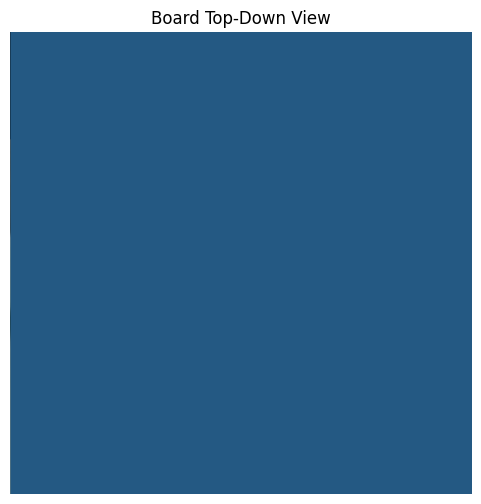

['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
FEN: 8/8/8/8/8/8/8/8 w - - 0 1
Valid FEN!
Processing 2 (6).jpeg...
Total contours found: 2052


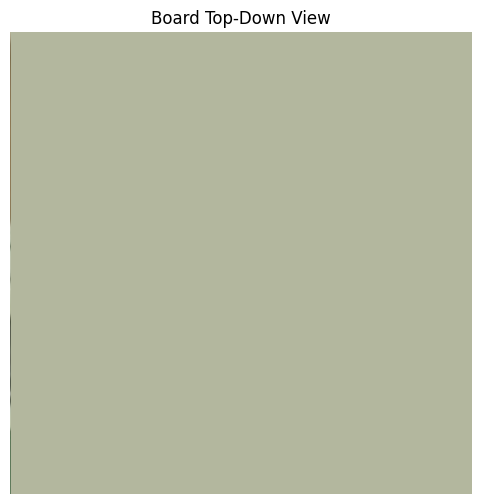

['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
FEN: 8/8/8/8/8/8/8/8 w - - 0 1
Valid FEN!
Processing 3 (6).jpeg...
Total contours found: 2001


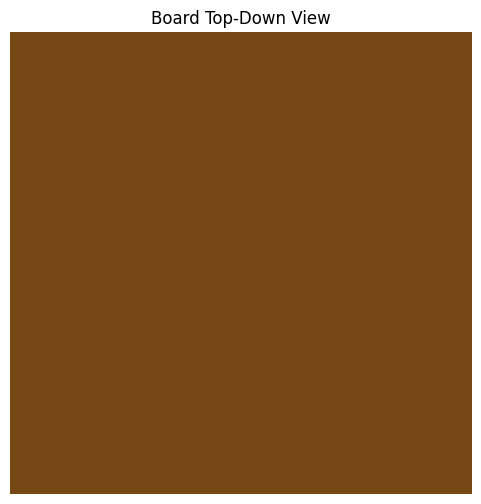

['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
FEN: 8/8/8/8/8/8/8/8 w - - 0 1
Valid FEN!
Processing 4 (6).jpeg...
Total contours found: 2361


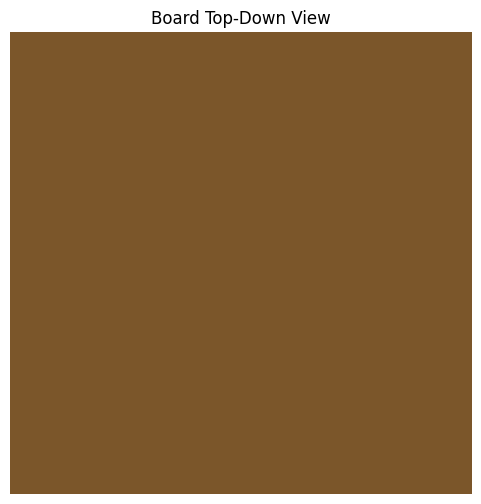

['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
FEN: 8/8/8/8/8/8/8/8 w - - 0 1
Valid FEN!
Processing 5 (6).jpeg...
Total contours found: 2788
No suitable 4-corner board contour found.
Trying fallback with largest contour bounding rect.


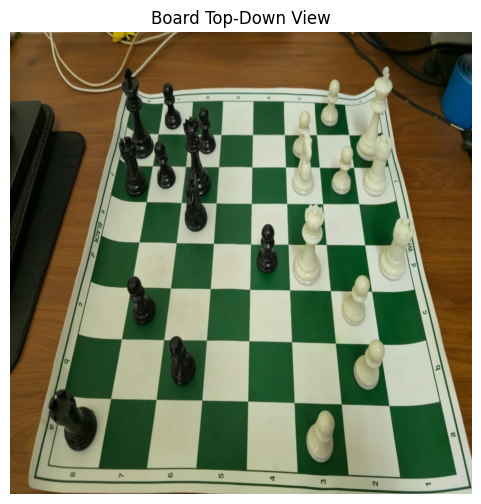

['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'p', 'P', 'p', 'P', 'P', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'p', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'P', 'p', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'P', 'P']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'P', 'unknown', 'unknown']
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
FEN: 8/2pPpPP1/5p2/3Pp3/6PP/8/5P2/8 w - - 0 1
Valid FEN!


In [ ]:
from google.colab import files

uploaded_files = files.upload()  # upload your chessboard images here

for fname in uploaded_files.keys():
    print(f"Processing {fname}...")
    fen_str = process_image(fname)
    with open(f"/content/{fname}.fen", "w") as f:
        f.write(fen_str)
